# Introduction
---
본 문서는 기본적인 컨볼루션 신경망(convolution neural networks)를 사용해 개와 고양이를 분류하는 문제를 푸는 과정을 다룹니다. 데이터는 [kaggle](https://www.kaggle.com/)의 [
Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)를 사용했습니다. 이번에 다루게 될 내용은 다음과 같습니다.<br>
* GPU 사용법
* Dataset, DataLoader 사용법
* 이미지 데이터 전처리
* 컨볼루션 신경망(convolutional neural networks) 구현

# Import libries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

# Configuration

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 256
TRAIN_PATH = './data/train/' 
TEST_PATH = './data/test/'

# Load the data
---
이번에는 이미지를 불러와야 합니다. 다른 종류의 데이터를 다루는 것과 크게 다른 점은 없습니다만, 이미지 데이터를 한 번도 다뤄본 적이 없다면 어떻게 해야 할지 막막할 수도 있겠습니다. [sci-kit image](https://scikit-image.org/)를 사용하면 간단하게 처리할 수 있습니다. 먼저, 첫 번째 이미지를 불러와보겠습니다.

In [3]:
from skimage import io

io.imread('./data/train/cat.0.jpg')

array([[[203, 164,  87],
        [203, 164,  87],
        [204, 165,  88],
        ...,
        [240, 201, 122],
        [239, 200, 121],
        [238, 199, 120]],

       [[203, 164,  87],
        [203, 164,  87],
        [204, 165,  88],
        ...,
        [241, 202, 123],
        [240, 201, 122],
        [238, 199, 120]],

       [[203, 164,  87],
        [203, 164,  87],
        [204, 165,  88],
        ...,
        [241, 202, 123],
        [240, 201, 122],
        [239, 200, 121]],

       ...,

       [[153, 122,  55],
        [153, 122,  55],
        [153, 122,  55],
        ...,
        [  2,   2,   0],
        [  2,   2,   0],
        [  2,   2,   0]],

       [[152, 121,  54],
        [152, 121,  54],
        [152, 121,  54],
        ...,
        [  2,   2,   0],
        [  2,   2,   0],
        [  2,   2,   0]],

       [[151, 120,  53],
        [151, 120,  53],
        [151, 120,  53],
        ...,
        [  1,   1,   0],
        [  1,   1,   0],
        [  1,   1,   0]]

_skimage.io.imread( )_를 사용하면 수치 데이터로 표현된 이미지의 모습(?)을 확인할 수 있습니다. 해당 이미지를 보고 싶다면 _skimage.io.imshow( )_ 함수나 _matplotlib_와 같은 시각화 라이브러리를 사용합니다(~~왠지 모르게 긴급한 상황에 처한 것 같은 고양이의 모습을 볼 수 있습니다~~). 더 자세한 설명은 [여기](https://matplotlib.org/users/image_tutorial.html)를 참고하시기 바랍니다.

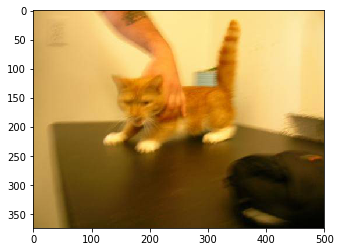

In [4]:
import matplotlib.pyplot as plt

plt.imshow(io.imread('./data/train/cat.0.jpg'))

이번에는 배치(batch) 단위의 학습을 손쉽게 진행하기 위해 PyTorch에서 제공하는 추상 클래스(abstract class)인 Dataset을 사용해보겠습니다. 먼저, 사용자가 새로 정의한 Dataset을 사용하려면, torch.utils.data.Dataset을 상속받아 \__len\__과 \__getitem\__을 재정의(override)해야 합니다.

In [5]:
from os import listdir
from os.path import join, isfile
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

class CatDogDataset(Dataset):
    def __init__(self, data_path, train=True, transform=None):
        self.data_path = data_path
        self.train = train
        self.transform = transform
        
        if self.train:
            data = np.array([[f, f[:3]]for f in listdir(self.data_path) if isfile(join(self.data_path, f))]) # dog, cat만 추출
            label_encoder = LabelEncoder()
            self.image_list = data[:,0]
            self.label_list = label_encoder.fit_transform(data[:,1])
        else:
            data = np.array([[f, f[:-4]]for f in listdir(self.data_path) if isfile(join(self.data_path, f))]) # 확장자 제거
            self.image_list = data[:,0]
            self.file_name = data[:,1]
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        img_name = join(self.data_path, self.image_list[idx])
        image = io.imread(img_name)
        
        if self.train:
            sample = {'image': image, 'label': self.label_list[idx]}
        else:
            sample = {'image': image, 'file_name': self.file_name[idx]}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

0 (375, 499, 3)
1 (332, 500, 3)
2 (374, 500, 3)
3 (374, 500, 3)


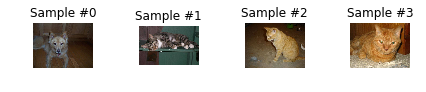

In [6]:
dataset = CatDogDataset(data_path='./data/train/')

fig = plt.figure()

for i in range(len(dataset)):
    sample = dataset[i]
    
    print(i, sample['image'].shape)
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])
    
    if i == 3:
        plt.show()
        break

# Data preprocessing
---
위의 결과를 보면 이미지의 크기가 제각각임을 알 수 있습니다. [여기](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html?highlight=dataset)를 참고해 고정된 크기의 이미지로 맞춰주는 코드를 작성합니다.

In [7]:
from skimage import transform

class Rescale(object):
    def __init__(self, output_size, train=True):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        self.train = train
        
    def __call__(self, sample):
        if self.train:
            image, label = sample['image'], sample['label']
        else:
            image, file_name = sample['image'], sample['file_name']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        
        if self.train:
            return {'image': img, 'label': label}
        else:
            return {'image': img, 'file_name': file_name}

In [8]:
class RandomCrop(object):
    def __init__(self, output_size, train=True):
        self.train = train
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        if self.train:
            image, label = sample['image'], sample['label']
        else:
            image, file_name = sample['image'], sample['file_name']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top: top + new_h, left: left + new_w]
        
        if self.train:
            return {'image': image, 'label': label}
        else:
            return {'image': image, 'file_name': file_name}

In [9]:
class ToTensor(object):
    def __init__(self, train=True):
        self.train = train
        
    def __call__(self, sample):
        if self.train:
            image, label = sample['image'], sample['label']
        else:
            image, file_name = sample['image'], sample['file_name']
        image = image.transpose((2, 0, 1))
        
        if self.train:
            return {'image': torch.from_numpy(image).float(), 'label': torch.tensor(label, dtype=torch.long)}
        else:
            return {'image': torch.from_numpy(image).float(), 'file_name': file_name}

/home/ultron/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


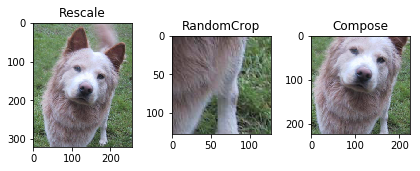

In [10]:
from torchvision import transforms, utils

scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

fig = plt.figure()
sample = dataset[756]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(transformed_sample['image'])

plt.show()

In [11]:
transformed_dataset = CatDogDataset(data_path='./data/train/', 
                                    transform=transforms.Compose([
                                        Rescale(256), 
                                        RandomCrop(224), 
                                        ToTensor()
                                    ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i, sample['image'].size(), sample['label'])
    
    if i == 3:
        break

0 torch.Size([3, 224, 224]) tensor(1)
1 torch.Size([3, 224, 224]) tensor(0)
2 torch.Size([3, 224, 224]) tensor(0)
3 torch.Size([3, 224, 224]) tensor(0)


/home/ultron/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [12]:
data_loader = DataLoader(transformed_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=True)

# Build the model
---
이번에는 2개의 컨볼루션층(convolutional layer)과 1개의 완전연결층(fully connected layer)으로 구성된 모델을 만들어보도록 하겠습니다. 첫 번째 층에서는 크기가 3\*3인 필터 32개를 만들고 최대 풀링(max pooling)을 해줍니다. 두 번째 층에서도 필터를 64개 만들어낸다는 점만 빼고 첫 번째 층과 동일한 과정을 거칩니다. 그리고 마지막에 분류를 위해 완전연결층을 쌓아줍니다.

In [13]:
class CNN(nn.Module):
    def __init__(self, n_classes=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # 32(batch) * 16(filter) * 224 * 224 
                                   nn.BatchNorm2d(16), 
                                   nn.ReLU(), 
                                   nn.MaxPool2d(2, stride=2) # 32 * 16 * 112 * 112
                                  )
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # 32 * 32 * 112 * 112
                                   nn.BatchNorm2d(32),
                                   nn.ReLU(), 
                                   nn.MaxPool2d(2, stride=2) # 32 * 32 * 56 * 56
                                  )
        self.fc = nn.Sequential(nn.Linear(56*56*32, 128), nn.ReLU(), nn.Linear(128, n_classes), nn.Softmax(dim=1))
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.reshape(out.size(0), -1) # 완전연결층에 맞게 펼쳐주는 역할
        out = self.fc(out)
        
        return out

새로 추가된 요소들은 다음과 같습니다.

* torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)
* torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
* torch.nn.ReLU(inplace=False)
* torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)

이들에 대해 설명하도록 하겠습니다.

## Convolutional Layer
---
기존 인공신경망과 컨볼루션 신경망의 가장 큰 차이점은 컨볼루션층(convolution layer)의 존재 여부입니다. 완전연결층(fully connected layer)는 입력 데이터의 전체적인 특징을 학습하는 반면, 컨볼루션 레이어는 특정 부분의 패턴을 학습한다고 볼 수 있습니다. 이런 구조로 인해 컨볼루션 신경망은 다음과 같은 특징을 가지게 됩니다.

1. 위치에 종속되지 않는 패턴 학습
    * 오른쪽 아래 모퉁이에 있는 패턴을 학습하고 나면 그 패턴이 다른 위치(예: 왼쪽 위)에 있어도 찾아낼 수 있게 됩니다.
    * 이런 특징 덕분에 더 적은 학습 데이터를 가지고도 좋은 일반화 성능을 낼 수 있습니다.
    
    
2. 패턴의 공간적 계층구조 학습
    * 하위 컨볼루션층은 점, 선, 면과 같은 작은 부분 패턴을 학습하고, 상위 컨볼루션층은 하위 층의 결과들로 구성된 더 큰 패턴을 학습합니다.
    * 이런 학습 과정을 통해 추상적이고 점점 복잡해지는 시각적 개념을 효과적으로 학습할 수 있게 됩니다.

## ReLU Activation
---
_Rectified Linear Unit_(ReLU)은 아래 그림과 같은 형태의 활성함수입니다. 이런 형태를 가지게 됨으로써 얻는 이점은 다음과 같습니다.

* 양의 영역이 선형이기 때문에 _tanh_나 _sigmoid_에서 발생하는 포화(saturation)현상이 발생하지 않는다. 
* 음의 영역은 모두 0이 되므로 신경망이 희소(sparse)해지게 된다.

첫 번째 이점은 직관적으로 그럴듯해 보입니다. 그런데 두 번째 이점, 즉, 신경망이 희소해지면 어떤 점이 좋을까요? 그에 대한 대답은 Ian J. Goodfellow와 그의 동료들이 진행한 일련의 실험에서 찾을 수 있습니다. 그들은 심층 신경망(deep neural networks)의 불변성(invariance; 입력 변수들이 변환 과정을 거치더라도 예측값이 변하지 않는 속성. 더 자세한 내용은 [여기](https://stats.stackexchange.com/questions/208936/what-is-translation-invariance-in-computer-vision-and-convolutional-neural-netwo)를 참고하시기 바랍니다)을 찾아내는 능력을 측정하기 위한 테스트를 진행했는데, 신기하게도 신경망이 희소해졌을 때 불변성을 더 잘 학습한다는 것을 발견했습니다.<br>

하지만, ReLU 활성함수는 이런 장점들에도 불구하고, 다음과 같은 잠재적인 문제점을 가지고 있습니다.

* 0에서 미분이 불가능하기 때문에 그레이디언트(gradient)의 전파가 되지 않는 상황이 발생할 수 있다. 
* 활성함수를 거친 출력값의 경계가 존재하지 않는다.

전자의 경우 이론상 문제가 될 수 있으나, 실제 사용에 있어서는 큰 문제가 되지 않습니다. 왜냐하면 신경망에는 여러 개의 뉴런(neuron)이 존재하고 수많은 경로로 그레이디언트가 흐르게 되는데, 한 층(layer)의 모든 노드가 0이 되는 경우는 거의 발생하지 않기 때문입니다. Xaveir Glorot과 그의 동료들은 이런 경우가 정말로 문제가 되는지 알아보기 위해 ReLU와 비슷한 형태를 가지면서 모든 구간에서 미분 가능한 softplus 활성함수와 성능을 비교하는 실험을 진행했는데, ReLU 활성함수가 더 좋은 성능을 낸다는 것을 밝혀냈습니다.<br>
후자의 경우 $L_1$ penalty와 같은 규제(regularization) 기법을 통해 해소할 수 있습니다.<br>

>참고 문헌
* [Measuring Invariances in Deep Networks](https://papers.nips.cc/paper/3790-measuring-invariances-in-deep-networks)
* [Deep Sparse Retifier Neural Network](http://proceedings.mlr.press/v15/glorot11a.html)

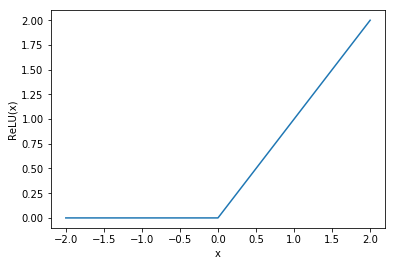

In [14]:
x = range(-2,3)
y = nn.functional.relu(torch.tensor(x)).tolist()
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.show()

## Variants of ReLU
---
앞서 기술했듯이 ReLU 활성 함수는 그레이디언트가 전파되지 않는 문제를 해소할 수 있고, 계산에 드는 비용도 적지만 단점이 없는 것은 아닙니다. 학습 중에 가중치가 갱신되는 과정에서 음의 값을 가지게 되면 ReLU를 거치면서 0이 되게 되는데, 이렇게 0이 된 뉴런은 그레이디언트 역시 0이 되므로 학습이 계속되어도 다시 살아날 수 없게 되는 현상이 발생합니다(이런 문제를 _dying ReLUs_라 부릅니다). 이런 문제점은 연구자들로 하여금 포화현상이 발생하지 않으면서 ReLU보다 더 좋은 성능을 낼 수 있는 활성함수를 고안하게 하는 동기가 되었고 dying ReLUs를 개선한 ReLU의 변형들이 등장하게 됩니다.

### Leaky ReLU Activation
---
_Leaky ReLU_는 $LeakyReLU_a(z)=max(az,z)$로 정의합니다. 여기서 $a$는 음수 부분의 기울기 즉, 얼마나 "새게 할지" 결정하는 hyperparameter입니다.

### PReLU Activation
---
_Parametric ReLU_(PReLU)는 $a$가 고정되어 있는 _Leaky ReLU_와 달리 신경망의 학습이 진행되면서 $a$도 같이 학습됩니다.

>참고 문헌
* [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852)

### ELU Activation
---
_Exponential Linear Unit_(ELU)는 음수 부분에 지수를 취해준 형태의 활성함수입니다.

>참고 문헌
[Fast and Accurate Deep Network Learning by Exponential Linear Units](https://arxiv.org/abs/1511.07289)

## Batch Normalization
---
인공신경망이 깊어짐에 따라 학습이 힘들어지는 이유 중 하나는 학습이 진행됨에 따라 가중치가 갱신되기 때문에 각 층의 입력값 분포가 변화하기 때문입니다. 다시 말해, 첫 번째 층에는 트레이닝 데이터가 아무런 변환도 없이 그대로 입력되지만 두 번째 층부터는 학습이 진행되면서 갱신되는 가중치에 의해 변형된 트레이닝 데이터가 전달되게 되는 것입니다. 이처럼 학습 도중에 샘플의 분포가 바뀌는 현상을 covariate shift라고 합니다. 층이 깊어질수록 원래의 트레이닝 데이터가 더욱 변형되므로, covariate shitf 현상이 심해집니다.<br>
배치 정규화(batch normalization)은 모든 층에 독립적으로 정규화를 적용해 covariate shift 현상을 줄이는 기법입니다. 배치 정규화가 적용되는 지점은 이전 층의 연산 결과가 다음 층에 입력될 때 혹은, 각 층에서 선형 연산을 끝내고 활성함수에 들어가기 전인데, Sergey Ioffe와 Christian Szegedy는 실험을 통해 후자의 경우가 더 좋은 성능을 낸다고 결론내렸습니다.

>참고 문헌
* [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

In [15]:
classifier = CNN().to(DEVICE)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.00001)

# Train the model

In [16]:
import time

for epoch in range(300):
    t = time.time()
    for step, mini_batch in enumerate(data_loader):
        optimizer.zero_grad()
        pred = classifier(mini_batch['image'].to(DEVICE))
        loss = loss_func(pred, mini_batch['label'].to(DEVICE))
        loss.backward()
        optimizer.step()
    
    t = time.time() - t
    print(epoch+1, 'epoch = {} seconds'.format('%.3f' % t))

/home/ultron/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


1 epoch = 238.847 seconds
2 epoch = 237.215 seconds
3 epoch = 238.959 seconds
4 epoch = 238.675 seconds
5 epoch = 238.209 seconds
6 epoch = 237.488 seconds
7 epoch = 236.698 seconds
8 epoch = 237.590 seconds
9 epoch = 238.111 seconds
10 epoch = 238.133 seconds
11 epoch = 237.587 seconds
12 epoch = 237.184 seconds
13 epoch = 237.223 seconds
14 epoch = 236.601 seconds
15 epoch = 236.979 seconds
16 epoch = 237.417 seconds
17 epoch = 237.347 seconds
18 epoch = 237.223 seconds
19 epoch = 236.935 seconds
20 epoch = 236.556 seconds
21 epoch = 237.804 seconds
22 epoch = 236.830 seconds
23 epoch = 237.250 seconds
24 epoch = 238.428 seconds
25 epoch = 237.499 seconds
26 epoch = 238.532 seconds
27 epoch = 237.284 seconds
28 epoch = 236.871 seconds
29 epoch = 236.926 seconds
30 epoch = 236.352 seconds
31 epoch = 237.068 seconds
32 epoch = 237.500 seconds
33 epoch = 236.476 seconds
34 epoch = 236.659 seconds
35 epoch = 236.359 seconds
36 epoch = 236.517 seconds
37 epoch = 236.745 seconds
38 epoch =

298 epoch = 237.465 seconds
299 epoch = 236.909 seconds
300 epoch = 237.024 seconds


# Prediction

In [47]:
test_dataset = CatDogDataset(data_path='./data/test/', train=False,  
                             transform=transforms.Compose([
                                 Rescale(256, train=False), 
                                 RandomCrop(224, train=False), 
                                 ToTensor(train=False)
                             ]))

test_loader = DataLoader(test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False
                        )

classifier.eval()
prediction = list()
with torch.no_grad():
    for step, mini_batch in enumerate(test_loader):
        pred = classifier(mini_batch['image'].to(DEVICE))
        lst = [[int(file_name), 1-prob] for file_name, prob in zip(mini_batch['file_name'], pred[:,0].tolist())]
        prediction.extend(lst)
    

/home/ultron/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [48]:
prediction.sort(key=lambda x : x[0])
prediction = [['id', 'label']] + prediction
prediction`

[['id', 'label'],
 [1, 0.9983064460102469],
 [2, 0.9999647197328159],
 [3, 0.012162089347839355],
 [4, 0.9999999998123313],
 [5, 0.002084791660308838],
 [6, 0.06872457265853882],
 [7, 9.298324584960938e-06],
 [8, 0.9091029837727547],
 [9, 0.018328607082366943],
 [10, 0.07606208324432373],
 [11, 0.00036907196044921875],
 [12, 0.9999961990008615],
 [13, 0.00011873245239257812],
 [14, 7.081031799316406e-05],
 [15, 0.9760919846594334],
 [16, 0.00022274255752563477],
 [17, 0.9979713128414005],
 [18, 0.9863249761983752],
 [19, 0.9417533241212368],
 [20, 0.00638127326965332],
 [21, 0.9076557084918022],
 [22, 0.000978231430053711],
 [23, 0.761002779006958],
 [24, 0.992329393979162],
 [25, 0.9512107335031033],
 [26, 0.48465901613235474],
 [27, 0.9185627400875092],
 [28, 0.00010645389556884766],
 [29, 0.9892214592546225],
 [30, 0.9999908820473138],
 [31, 0.995305793825537],
 [32, 0.04730725288391113],
 [33, 0.9999970566582306],
 [34, 0.0021911263465881348],
 [35, 0.07083261013031006],
 [36, 0.00

In [49]:
import csv

with open('./data/dogs_cats.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerows(prediction)